# Setup

## Load packages

In [ ]:
install.packages("caret")

library(tidyverse)  # Data wrangling packages.

my_bucket <- Sys.getenv('WORKSPACE_BUCKET')

library(glmnet)
library(dplyr)
library(pROC)
library(broom)
library(caret)

Installing package into ‘/home/jupyter/packages’
(as ‘lib’ is unspecified)



## Load and merge data

In [ ]:
name_of_file_in_bucket <- 'Demographic_and_ancestry_covariates.csv'
system(paste0("gsutil cp ", my_bucket, "/data/", name_of_file_in_bucket, " ."), intern=T)
demo  <- read_csv(name_of_file_in_bucket) |> 
    select(-c(income, education)) |> 
    rename(age = age_at_last_event)

name_of_file_in_bucket <- 'SES_data.csv'
system(paste0("gsutil cp ", my_bucket, "/data/", name_of_file_in_bucket, " ."), intern=T)
ses_data  <- read_csv(name_of_file_in_bucket)

all_data <- merge(
  demo,
  ses_data,
  by = "person_id"
)

name_of_file_in_bucket <- 'Case_Control_df.csv'
system(paste0("gsutil cp gs://fc-secure-672eeb92-4859-4ed9-9f59-d4349f3534a0/notebooks/Case_Control_df.csv ."), intern=T)
case_control  <- read_csv(name_of_file_in_bucket)

merged_data<-merge(all_data, case_control, on="person_id", how="inner")

## Format data

In [7]:
merged_data <- merged_data %>%
  mutate(
    SexGenderCis_male = ifelse(SexGender == "Cis_male", 1, 0),
    SexGenderCis_female = ifelse(SexGender == "Cis_female", 1, 0),
    SexGenderSGM = ifelse(SexGender == "SGM", 1, 0)
  )

merged_data$age2 <- merged_data$age^2

domains<-c('per_poverty_threshold', 'education', 
           'fraction_assisted_income', 'fraction_high_school_edu', 'median_income', 
           'fraction_no_health_insurance', 'fraction_poverty', 'fraction_vacant_housing', 'deprivation_index')       


#Hard code to match disease names in case_control dataframe 
diseases<-c("Asthma", "Afib", "BreastC", "CKD", "CHD", "ProstateC", "t2d", "t1d")

# Elastic Net Function

In [4]:
run_elastic_net <- function(diseases, selection_terms, merged_data) {

  ####---------------------------------------------------------------
  #### 1. Containers
  ####---------------------------------------------------------------

  summary_cols <- c(
    "mean_train_score", "sd_train_score",
    "mean_test_score",  "sd_test_score",
    "mean_AUC",         "sd_AUC",
    "n_predictors",     "Predictors"
  )

  model_summary <- matrix(NA, nrow = length(diseases), ncol = length(summary_cols))
  colnames(model_summary) <- summary_cols
  rownames(model_summary) <- diseases
  model_summary <- as.data.frame(model_summary)

  individual_scores <- list()
  weights_list      <- list()

  set.seed(123)

  ####---------------------------------------------------------------
  #### 2. Loop over diseases
  ####---------------------------------------------------------------

  for (disease in diseases) {

    df <- merged_data %>%
      select(person_id, all_of(disease), all_of(selection_terms)) %>%
      drop_na()

    X <- as.matrix(df %>% select(all_of(selection_terms)))
    y <- as.numeric(df[[disease]])

    penalty_factors <- rep(1, ncol(X))

    ####-----------------------------------------------------------
    #### 3. Cross-validation (performance estimation ONLY)
    ####-----------------------------------------------------------

    n_splits     <- 5
    train_scores <- c()
    test_scores  <- c()
    aucs         <- c()

    for (i in seq_len(n_splits)) {

      idx_train <- createDataPartition(y, p = 0.7, list = FALSE)

      X_train <- X[idx_train, , drop = FALSE]
      X_test  <- X[-idx_train, , drop = FALSE]
      y_train <- y[idx_train]
      y_test  <- y[-idx_train]

      # ---- train-only scaling ----
      scale_min <- apply(X_train, 2, min)
      scale_max <- apply(X_train, 2, max)
      scale_rng <- scale_max - scale_min
      scale_rng[scale_rng == 0] <- 1

      X_train <- sweep(sweep(X_train, 2, scale_min, "-"), 2, scale_rng, "/")
      X_test  <- sweep(sweep(X_test,  2, scale_min, "-"), 2, scale_rng, "/")

      cv_fit <- cv.glmnet(
        X_train, y_train,
        alpha = 0.5,
        family = "binomial",
        penalty.factor = penalty_factors
      )

      lambda_best <- cv_fit$lambda.min

      fit <- glmnet(
        X_train, y_train,
        alpha = 0.5,
        lambda = lambda_best,
        family = "binomial",
        penalty.factor = penalty_factors
      )

      # performance
      preds_test <- predict(fit, X_test, type = "link")
      test_scores  <- c(test_scores, cor(preds_test, y_test))
      train_scores <- c(train_scores, cv_fit$cvm[cv_fit$lambda == lambda_best])

      aucs <- c(
        aucs,
        as.numeric(assess.glmnet(cv_fit, newx = X_train, newy = y_train)$auc)
      )
    }

    ####-----------------------------------------------------------
    #### 4. Full-data refit (FINAL MODEL FOR WEIGHTS)
    ####-----------------------------------------------------------

    scale_min_full <- apply(X, 2, min)
    scale_max_full <- apply(X, 2, max)
    scale_rng_full <- scale_max_full - scale_min_full
    scale_rng_full[scale_rng_full == 0] <- 1

    X_scaled <- sweep(sweep(X, 2, scale_min_full, "-"), 2, scale_rng_full, "/")

    cv_full <- cv.glmnet(
      X_scaled, y,
      alpha = 0.5,
      family = "binomial",
      penalty.factor = penalty_factors
    )

    lambda_final <- cv_full$lambda.min

    final_fit <- glmnet(
      X_scaled, y,
      alpha = 0.5,
      lambda = lambda_final,
      family = "binomial",
      penalty.factor = penalty_factors
    )

    coef_final <- as.vector(coef(final_fit))
    names(coef_final) <- rownames(coef(final_fit))

    ####-----------------------------------------------------------
    #### 5. Store weights + scaling metadata
    ####-----------------------------------------------------------

    weights_list[[disease]] <- tibble(
      Disease     = disease,
      Predictor   = names(coef_final),
      weight      = coef_final,
      scale_min   = c(0, scale_min_full),
      scale_max   = c(1, scale_max_full),
      scale_range = c(1, scale_rng_full)
    )

    ####-----------------------------------------------------------
    #### 6. Compute individual PsRS (reference scores)
    ####-----------------------------------------------------------

    Xb <- X_scaled %*% coef_final[-1] + coef_final[1]

    individual_scores[[disease]] <- tibble(
      person_id = df$person_id,
      prediction = as.numeric(Xb)
    )

    ####-----------------------------------------------------------
    #### 7. Populate summary table
    ####-----------------------------------------------------------

    nz <- coef_final[-1] != 0

    model_summary[disease, ] <- list(
      mean(train_scores),
      sd(train_scores),
      mean(test_scores),
      sd(test_scores),
      mean(aucs),
      sd(aucs),
      sum(nz),
      paste(names(coef_final[-1])[nz], collapse = ", ")
    )

    message("Completed Elastic Net for: ", disease)
  }

  ####---------------------------------------------------------------
  #### 8. Final weights tables
  ####---------------------------------------------------------------

  scales <- bind_rows(weights_list) |> select(-c(weight))
  weights_long <- bind_rows(weights_list)

  weights_wide <- weights_long %>%
    select(Disease, Predictor, weight) %>%
    pivot_wider(names_from = Disease, values_from = weight)

  ####---------------------------------------------------------------
  #### 9. Return
  ####---------------------------------------------------------------

  list(
    model_summary     = model_summary,
    individual_scores = individual_scores,
    scales            = scales,
    weights_wide      = weights_wide
  )
}


# Run ENs

In [5]:
results_all <- run_elastic_net(diseases, domains, merged_data)


Completed Elastic Net for: Asthma

Completed Elastic Net for: Afib

Completed Elastic Net for: BreastC

Completed Elastic Net for: CKD

Completed Elastic Net for: CHD

Completed Elastic Net for: ProstateC

Completed Elastic Net for: t2d

Completed Elastic Net for: t1d



In [6]:
selection_terms_no_income<-c('education', 
           'fraction_assisted_income', 'fraction_high_school_edu', 'median_income', 
           'fraction_no_health_insurance', 'fraction_poverty', 'fraction_vacant_housing', 'deprivation_index')       


results_no_income <- run_elastic_net(diseases, selection_terms_no_income, merged_data)


Completed Elastic Net for: Asthma

Completed Elastic Net for: Afib

Completed Elastic Net for: BreastC

Completed Elastic Net for: CKD

Completed Elastic Net for: CHD

Completed Elastic Net for: ProstateC

Completed Elastic Net for: t2d

Completed Elastic Net for: t1d



# Save files

## Reporting

In [7]:
write_excel_csv(results_all[[1]], 'elastic_net_results.csv')
# Copy the file from current workspace to the bucket
system(paste0("gsutil cp ./elastic_net_results.csv ", my_bucket, "/data/"), intern=T)

write_excel_csv(results_no_income[[1]], 'elastic_net_results_no_income.csv')
# Copy the file from current workspace to the bucket
system(paste0("gsutil cp ./elastic_net_results_no_income.csv ", my_bucket, "/data/"), intern=T)

character(0)

character(0)

## Weights Files

In [8]:
write_excel_csv(results_all[[4]], 'PsRS_weights_file.csv')
# Copy the file from current workspace to the bucket
system(paste0("gsutil cp ./PsRS_weights_file.csv ", my_bucket, "/data/"), intern=T)


write_excel_csv(results_no_income[[4]], 'PsRS_weights_file_no_income.csv')
# Copy the file from current workspace to the bucket
system(paste0("gsutil cp ./PsRS_weights_file_no_income.csv ", my_bucket, "/data/"), intern=T)

character(0)

character(0)

## Scaling Files

In [9]:
write_excel_csv(results_all[[3]], 'PsRS_scaling_file.csv')
# Copy the file from current workspace to the bucket
system(paste0("gsutil cp ./PsRS_scaling_file.csv ", my_bucket, "/data/"), intern=T)


write_excel_csv(results_no_income[[3]], 'PsRS_scaling_file_no_income.csv')
# Copy the file from current workspace to the bucket
system(paste0("gsutil cp ./PsRS_scaling_file_no_income.csv ", my_bucket, "/data/"), intern=T)

character(0)

character(0)

# Calculate PsRS using AoU weights

In [2]:
name_of_file_in_bucket <- 'PsRS_weights_file_no_income.csv'
system(paste0("gsutil cp ", my_bucket, "/data/", name_of_file_in_bucket, " ."), intern=T)
PsRS_weights_no_income <- read_csv(name_of_file_in_bucket)

name_of_file_in_bucket <- 'PsRS_weights_file.csv'
system(paste0("gsutil cp ", my_bucket, "/data/", name_of_file_in_bucket, " ."), intern=T)
PsRS_weights <- read_csv(name_of_file_in_bucket)

name_of_file_in_bucket <- 'PsRS_scaling_file_no_income.csv'
system(paste0("gsutil cp ", my_bucket, "/data/", name_of_file_in_bucket, " ."), intern=T)
PsRS_scaling_no_income <- read_csv(name_of_file_in_bucket)

name_of_file_in_bucket <- 'PsRS_scaling_file.csv'
system(paste0("gsutil cp ", my_bucket, "/data/", name_of_file_in_bucket, " ."), intern=T)
PsRS_scaling <- read_csv(name_of_file_in_bucket)

character(0)

Rows: 9 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): Predictor
dbl (8): Asthma, Afib, BreastC, CKD, CHD, ProstateC, t2d, t1d

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


character(0)

Rows: 10 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): Predictor
dbl (8): Asthma, Afib, BreastC, CKD, CHD, ProstateC, t2d, t1d

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


character(0)

Rows: 72 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): Disease, Predictor
dbl (3): scale_min, scale_max, scale_range

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


character(0)

Rows: 80 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): Disease, Predictor
dbl (3): scale_min, scale_max, scale_range

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


## PsRS with income

In [ ]:
# ---- 0. Add intercept ----
all_data_with_intercept <- all_data %>%
  mutate(`(Intercept)` = 1)

# ---- 1. Pivot all_data to long for predictors only ----
long_data <- all_data_with_intercept %>%
  pivot_longer(
    cols = c(all_of(domains), `(Intercept)`),
    names_to = "Predictor",
    values_to = "value"
  )

# ---- 2. Pivot weights to long ----
weights_long <- PsRS_weights %>%
  pivot_longer(
    cols = all_of(diseases),
    names_to = "Disease",
    values_to = "coef"
  )

# ---- 3. Expand for each disease ----
# Create all combinations of person_id, Predictor, and disease
long_data_expanded <- expand_grid(
  person_id = unique(all_data$person_id),
  Predictor = unique(long_data$Predictor),
  Disease = diseases
) %>%
  left_join(long_data, by = c("person_id", "Predictor"))

# ---- 4. Join weights and scaling ----
long_data_scaled <- long_data_expanded %>%
  left_join(weights_long, by = c("Predictor", "Disease")) %>%
  left_join(PsRS_scaling, by = c("Predictor", "Disease")) %>%
  mutate(
    value_scaled = if_else(
      Predictor == "(Intercept)",
      value,
      (value - scale_min) / (scale_max - scale_min)
    ),
    score_part = value_scaled * coef
  )

# ---- 5. Aggregate to compute PsRS ----
score_wide <- long_data_scaled %>%
  group_by(person_id, Disease) %>%
  summarize(score = sum(score_part, na.rm = TRUE), .groups = "drop") %>%
  pivot_wider(
    names_from = Disease,
    values_from = score,
    values_fill = 0
  ) %>%
  rename_with(~ paste0(., "_PsRS"), -person_id)

# ---- 5. Save ----
write_excel_csv(score_wide, 'individual_PsRS.csv')
system(paste0("gsutil cp ./individual_PsRS.csv ", my_bucket, "/data/"), intern = TRUE)


In [ ]:
# Pivot to long format
scores_long <- score_wide %>%
  pivot_longer(
    cols = ends_with("_PsRS"),
    names_to = "disease",
    values_to = "score"
  )

# Plot facet-wrapped histograms
ggplot(scores_long, aes(x = score)) +
  geom_histogram(bins = 40, fill = "skyblue", color = "white") +
  facet_wrap(~ disease, scales = "free") +
  theme_minimal() +
  labs(
    title = "Distribution of PsRS",
    x = "Score",
    y = "Count"
  ) +
  theme(
    plot.title = element_text(size = 16, face = "bold"),
    strip.text = element_text(size = 12)
  )


## PsRS without income

character(0)

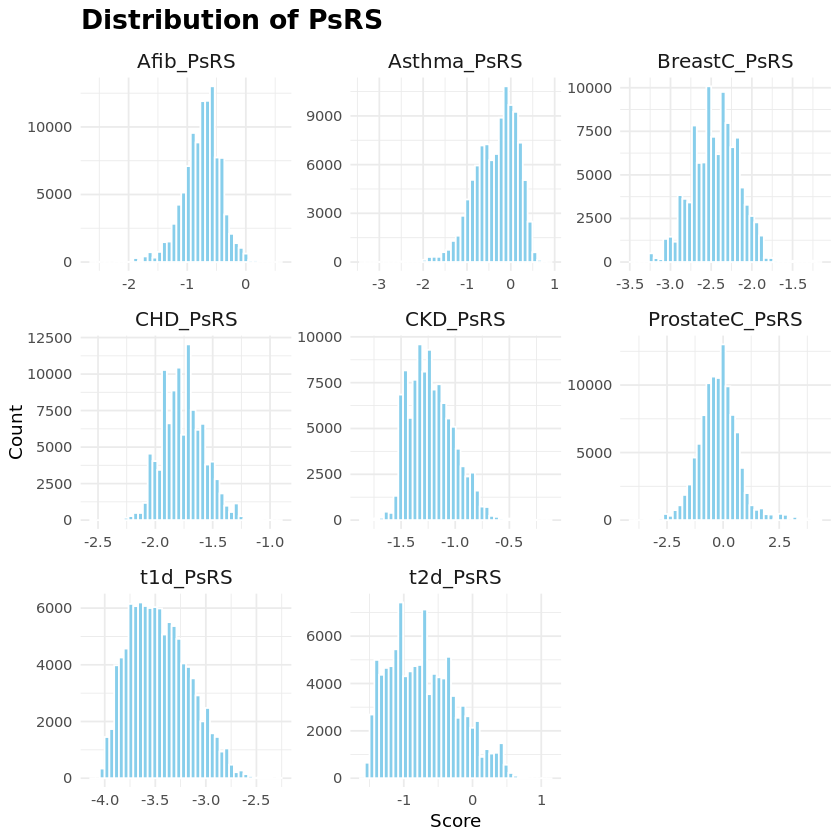

In [8]:
# ---- 0. Add intercept ----
all_data_with_intercept <- all_data %>%
  mutate(`(Intercept)` = 1)

# ---- 1. Pivot all_data to long for predictors only ----
long_data <- all_data_with_intercept %>%
  pivot_longer(
    cols = c(all_of(domains), `(Intercept)`),
    names_to = "Predictor",
    values_to = "value"
  )

# ---- 2. Pivot weights to long ----
weights_long <- PsRS_weights_no_income %>%
  pivot_longer(
    cols = all_of(diseases),
    names_to = "Disease",
    values_to = "coef"
  )

# ---- 3. Expand for each disease ----
# Create all combinations of person_id, Predictor, and disease
long_data_expanded <- expand_grid(
  person_id = unique(all_data$person_id),
  Predictor = unique(long_data$Predictor),
  Disease = diseases
) %>%
  left_join(long_data, by = c("person_id", "Predictor"))

# ---- 4. Join weights and scaling ----
long_data_scaled <- long_data_expanded %>%
  left_join(weights_long, by = c("Predictor", "Disease")) %>%
  left_join(PsRS_scaling_no_income, by = c("Predictor", "Disease")) %>%
  mutate(
    value_scaled = if_else(
      Predictor == "(Intercept)",
      value,
      (value - scale_min) / (scale_max - scale_min)
    ),
    score_part = value_scaled * coef
  )

# ---- 5. Aggregate to compute PsRS ----
score_wide <- long_data_scaled %>%
  group_by(person_id, Disease) %>%
  summarize(score = sum(score_part, na.rm = TRUE), .groups = "drop") %>%
  pivot_wider(
    names_from = Disease,
    values_from = score,
    values_fill = 0
  ) %>%
  rename_with(~ paste0(., "_PsRS"), -person_id)

# ---- 6. Save ----
write_excel_csv(score_wide, 'individual_PsRS_no_income.csv')
system(paste0("gsutil cp ./individual_PsRS_no_income.csv ", my_bucket, "/data/"), intern = TRUE)


# Pivot to long format
scores_long <- score_wide %>%
  pivot_longer(
    cols = ends_with("_PsRS"),
    names_to = "disease",
    values_to = "score"
  )

# Plot facet-wrapped histograms
ggplot(scores_long, aes(x = score)) +
  geom_histogram(bins = 40, fill = "skyblue", color = "white") +
  facet_wrap(~ disease, scales = "free") +
  theme_minimal() +
  labs(
    title = "Distribution of PsRS",
    x = "Score",
    y = "Count"
  ) +
  theme(
    plot.title = element_text(size = 16, face = "bold"),
    strip.text = element_text(size = 12)
  )
